In [1]:
!pip install folium -q

In [2]:
#Cell 0. Importing Libraries

import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
# Cell 1: Load Processed Data

try:

	input_file = "../data/df_final_with_cluster_A.pkl"
	print(f"Loading data: {input_file} ...")

	df_final = pd.read_pickle(input_file)

	print(f"{df_final.shape}")
	print(df_final.head().T)
	print(df_final.tail().T)

except FileNotFoundError:
	
	print(f"Error: File '{input_file}' not found.")
	exit(1)

Loading data: ../data/df_final_with_cluster_A.pkl ...
(2122338, 36)
                                              0                        1  \
dia_semana                        Segunda-Feira            Segunda-Feira   
data_hora                   2007-06-11 15:30:00      2007-06-11 15:30:00   
uf                                           MG                       MG   
br                                          381                      381   
km                                        623.2                    623.2   
municipio                              Oliveira                 Oliveira   
causa_acidente          Falta De Atenção/Reação  Falta De Atenção/Reação   
tipo_acidente                   Colisão Frontal          Colisão Frontal   
classificacao_acidente                      Nan                      Nan   
fase_dia                              Pleno Dia                Pleno Dia   
sentido_via                         Decrescente              Decrescente   
condicao_metereologi

Dataset Geoespacial ready: 560078 valid accidents.


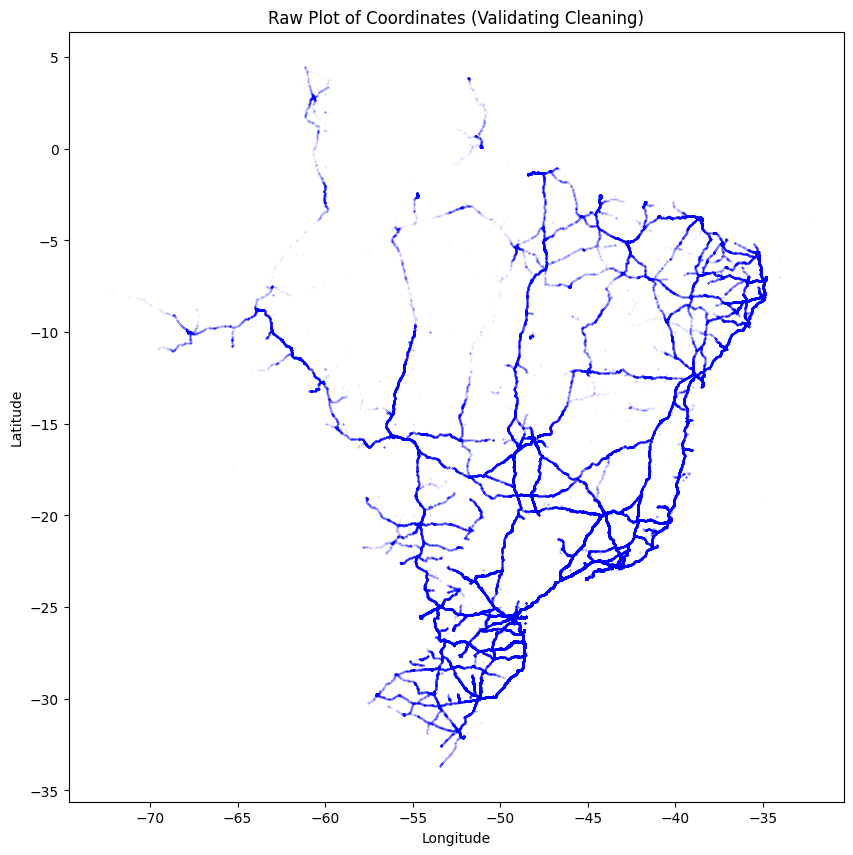

In [4]:
# Cell 2: Preparation for Cluster B (Geospatial - 2017+)

# Filter only the period with reliable GPS
df_geo = df_final[df_final['ano_base'] >= 2017].copy()

# Cleaning coordinates
df_geo = df_geo.dropna(subset=['latitude', 'longitude'])

# Remove impossibles coord
mask_brasil = (
	
	( df_geo['latitude'] 	<   6 ) & ( df_geo['latitude']	> -35 ) &
	( df_geo['longitude']	< -30 ) & ( df_geo['longitude']	> -75 ) &
	( df_geo['latitude'] 	!=  0 ) & ( df_geo['longitude']	!=  0 )
	
)

df_geo = df_geo[mask_brasil]

print(f"Dataset Geoespacial ready: {len(df_geo)} valid accidents.")

# 3. Conversion to Radians (Necessary for physical distance calculation in DBSCAN)
df_geo['lat_rad']  = np.radians(df_geo['latitude'])
df_geo['long_rad'] = np.radians(df_geo['longitude'])

# Quick Visualization to ensure it looks like the map of Brazil
plt.figure(figsize=(10, 10))
plt.scatter(df_geo['longitude'], df_geo['latitude'], s=0.1, alpha=0.1, c='blue')
plt.title("Raw Plot of Coordinates (Validating Cleaning)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [5]:
# Cell 3: Analysis Functions for Cluster B

# Leaderboard Function
def gerar_ranking_dinamico(df, cluster_col):
	"""
	Generates the danger ranking for a specific cluster column.
	"""
	# Noise filter (-1)
	df_clean = df[df[cluster_col] != -1]
	
	if len(df_clean) == 0:
		return None

	ranking = df_clean.groupby(cluster_col).agg({

		'ano_base': 'count',        # Qtd Accident
		'mortos': 'sum',            # Total deaths
		'feridos_graves': 'sum',    # Total serious injuries
		'uf': lambda x: x.mode()[0] if not x.mode().empty else "N/A",
		'br': lambda x: x.mode()[0] if not x.mode().empty else "N/A",
		'km': 'mean',

	}).rename(columns={'ano_base': 'Qtd_Accident'})
	
	# Risk Calculations
	ranking['Lethality (%)'] = (ranking['mortos'] / ranking['Qtd_Accident'] * 100).round(1)
	ranking['Severity (%)'] = ((ranking['mortos'] + ranking['feridos_graves']) / ranking['Qtd_Accident'] * 100).round(1)
	# Order by Deaths
	return ranking.sort_values('mortos', ascending=False)

# Main Function (The Scenario Machine)
def run_dbscan_battery(df, scenarios):

	KMS_PER_RADIAN = 6371.0088
	
	for eps_km, min_samples in scenarios:

		print(f"\n{'=' * 80}")
		print(f"SCENARIO: Radius {eps_km} km | Minimum {min_samples} accidents")
		print(f"{'-' * 40}")
		
		# Clustering
		eps_rad = eps_km / KMS_PER_RADIAN
		db = DBSCAN( eps = eps_rad, min_samples = min_samples, metric = 'haversine', algorithm = 'ball_tree', n_jobs = -1)
		
		# Create dynamic column name
		col_name = f'cluster_{eps_km}km_{min_samples}'
		
		# Train
		df[col_name] = db.fit_predict(df[['lat_rad', 'long_rad']])
		
		# General Statistics
		n_noise 	= list(df[col_name]).count(-1)
		n_clusters 	= len(set(df[col_name])) - (1 if -1 in df[col_name] else 0)
		
		print(f"\n** Clusters found: {n_clusters}")
		
		if n_clusters > 0:

			# Show Leaderboard (Top 5 of this scenario)
			ranking = gerar_ranking_dinamico(df, col_name)
			cols_show = ['Qtd_Accident', 'mortos', 'Lethality (%)', 'uf', 'br', 'km']
			
			print(f"\n*** TOP 5 MOST LETHAL ZONES (In This Scenario):")
			print(ranking[cols_show].head(5).to_string())
			
			# Generate HTML Map
			df_plot = df[df[col_name] != -1]
			df_noise = df[df[col_name] == -1].sample(n=min(5000, n_noise), random_state=42)
			df_map = pd.concat([df_plot, df_noise])
			
			# If there are still too many points, limit to 20k total points
			if len(df_map) > 20000: df_map = df_map.sample(n=20000, random_state=42)

			center_lat, center_long = df_map['latitude'].mean(), df_map['longitude'].mean()
			m = folium.Map(location=[center_lat, center_long], zoom_start=5, tiles='CartoDB positron')
			
			for _, row in df_map.iterrows():

				cluster_id = row[col_name]

				# Color: Gray if noise (-1), Red if lethal cluster, Blue if normal cluster
				if cluster_id == -1:
					color, fill, radius = 'lightgray', 0.3, 1

				elif row['mortos'] > 0:
					color, fill, radius = 'red', 0.7, 4

				else:
					color, fill, radius = 'blue', 0.6, 3
				
				folium.CircleMarker(

					location = [row['latitude'],
				 	row['longitude']],
					radius = radius,
					color = color,
					fill = True,
					fill_opacity = fill,
					popup = f"Cluster {cluster_id}"

				).add_to(m)
			
			# Add heatmap layer
			heat_data = [[row['latitude'], row['longitude']] for index, row in df_map.iterrows()]
			HeatMap(heat_data, radius=15, blur=20, min_opacity=0.4).add_to(m)
			
			filename = f"../data/maps/mapa_hotspots_raio{eps_km}km_min{min_samples}.html"
			m.save(filename)
			print(f"\n*** Saved in: {filename}")
		
		else:
			print("**** Error: No clusters found. Try decreasing min_samples or increasing the radius.")

In [6]:
# Cell 4: Excution run_dbscan_battery

# Some scenarios to test:
cenarios_para_testar = [
	
	(0.2, 10),   # MICRO: Find "The Death Curve" - "A Curva da Morte" (200m, 50 accidents)
	(1.0, 50),   # MESO: Find dangerous stretches (1km, 50 accidents)
	(5.0, 200)   # MACRO: Find chaotic metropolitan regions (5km, 200 accidents)
	
]

run_dbscan_battery(df_geo, cenarios_para_testar)


SCENARIO: Radius 0.2 km | Minimum 10 accidents
----------------------------------------

** Clusters found: 10083

*** TOP 5 MOST LETHAL ZONES (In This Scenario):
                  Qtd_Accident  mortos  Lethality (%)  uf   br          km
cluster_0.2km_10                                                          
162                       7241     278            3.8  SP  116  207.789338
155                      11565     199            1.7  SC  101  171.673212
83                        4678     151            3.2  MG  381  480.016075
275                       4170     132            3.2  PB  230   41.566211
70                        2828     126            4.5  RJ  116  173.933204

*** Saved in: ../data/maps/mapa_hotspots_raio0.2km_min10.html

SCENARIO: Radius 1.0 km | Minimum 50 accidents
----------------------------------------

** Clusters found: 830

*** TOP 5 MOST LETHAL ZONES (In This Scenario):
                  Qtd_Accident  mortos  Lethality (%)  uf   br          km
cluster_1.0

In [7]:
# Cell 5: Recriar o Cenário Vencedor para Análise Profunda

# Chosing the scenario that seemed most interesting in the tests above
RAIO_ESCOLHIDO = 0.2
MIN_ACIDENTES = 10

print(f"Recreating clusters for the scenario: Radius {RAIO_ESCOLHIDO}km | Minimum {MIN_ACIDENTES} accidents...")

KMS_PER_RADIAN = 6371.0088
eps_rad = RAIO_ESCOLHIDO / KMS_PER_RADIAN

db_final = DBSCAN(eps=eps_rad, min_samples=MIN_ACIDENTES, metric='haversine', algorithm='ball_tree', n_jobs=-1)

# Agora salvamos na coluna oficial 'cluster_B' para usar na análise
df_geo['cluster_B'] = db_final.fit_predict(df_geo[['lat_rad', 'long_rad']])

print("Recreated clusters saved in the 'cluster_B' column.")

Recreating clusters for the scenario: Radius 0.2km | Minimum 10 accidents...
Recreated clusters saved in the 'cluster_B' column.


In [10]:
# Cell 6: Cross-Analysis (Geo vs Behavioral)

# Ensure Cluster A data is present
if 'cluster_A' not in df_geo.columns:
    df_geo = df_geo.join(df_final['cluster_A'])

def analisar_dna_hotspot(df, cluster_id, scenario_col):
    """
    Analyzes a specific hotspot and displays a styled dataframe with its composition.
    """
    # Safety check
    if scenario_col not in df.columns:
        
        print(f"Error: Column '{scenario_col}' not found.")
        return

    # Filter data
    hotspot_data = df[df[scenario_col] == cluster_id]
    
    if len(hotspot_data) == 0:
        
        print(f"Cluster {cluster_id} not found in {scenario_col}.")
        return

    try:
        br = hotspot_data['br'].mode()[0]
        uf = hotspot_data['uf'].mode()[0]
        
    except:
        br, uf = "N/A", "N/A"
        
    total_acc = len(hotspot_data)
    total_dead = hotspot_data['mortos'].sum()
    lethality = (total_dead / total_acc * 100)
    avg_km = hotspot_data['km'].mean()
    
    print(f"\n* DNA ANALYSIS OF HOTSPOT: {cluster_id} | Scenario: {scenario_col}")
    print(f"Location: BR-{br} ({uf}) - Km {avg_km:.1f}")
    print(f"Total Accidents: {total_acc}")
    print(f"Total Deaths: {total_dead} (Lethality: {lethality:.1f}%)")
    print("\n* Composition by Accident Type (Cluster A):")

    # Count percentage
    contagem = hotspot_data['cluster_A'].value_counts(normalize=True) * 100
    
    # Mapping names
    mapeamento_nomes = {
        
        0: "Hazardous Terrain / Relief (Cluster A - 0)",
        1: "Infrastructure Bottleneck (Cluster A - 1)",
        2: "Curve Tangent (Cluster A - 2)",
        3: "Standard Flow / Straight (Cluster A - 3)",
        4: "Mass Casualty Event (Cluster A - 4)",
        5: "Urban Conflict / Crossing (Cluster A - 5)"
        
    }


    # Create list for DataFrame
    data_list = []
    
    for cid, pct in contagem.items():
        
        if cid != -1: # Ignore noise
            
            nome = mapeamento_nomes.get(cid, f"Type {cid}")
            
            data_list.append({
                
                "Profile": nome,
                "Share (%)": pct
                
            })
    
    # Display Dataframe if data exists
    if data_list:
        
        df_dna = pd.DataFrame(data_list)
        df_dna = df_dna.sort_values("Share (%)", ascending=False).reset_index(drop=True)
        
        # Clean style: Simple bar, serious color, percentage format
        styled_table = df_dna.style.bar(subset=['Share (%)'], color='#d65f5f', vmin=0, vmax=100).format({'Share (%)': '{:.1f}%'})
        
        display(styled_table)
        
    else:
        print("No behavioral clusters identified.")
    
    print("-" * 60)

print("* Analyzing Micro Hotspots...")
analisar_dna_hotspot(df_geo, 162, scenario_col='cluster_0.2km_10') 
analisar_dna_hotspot(df_geo, 155, scenario_col='cluster_0.2km_10')

print("\n* Analyzing Macro Regions...")
analisar_dna_hotspot(df_geo, 1, scenario_col='cluster_5.0km_200')
analisar_dna_hotspot(df_geo, 18, scenario_col='cluster_5.0km_200')

* Analyzing Micro Hotspots...

* DNA ANALYSIS OF HOTSPOT: 162 | Scenario: cluster_0.2km_10
Location: BR-116 (SP) - Km 207.8
Total Accidents: 7241
Total Deaths: 278 (Lethality: 3.8%)

* Composition by Accident Type (Cluster A):


,Profile,Share (%)
0,Standard Flow / Straight (Cluster A - 3),75.7%
1,Mass Casualty Event (Cluster A - 4),9.0%
2,Hazardous Terrain / Relief (Cluster A - 0),8.5%
3,Curve Tangent (Cluster A - 2),2.8%
4,Infrastructure Bottleneck (Cluster A - 1),2.8%
5,Urban Conflict / Crossing (Cluster A - 5),1.2%


------------------------------------------------------------

* DNA ANALYSIS OF HOTSPOT: 155 | Scenario: cluster_0.2km_10
Location: BR-101 (SC) - Km 171.7
Total Accidents: 11565
Total Deaths: 199 (Lethality: 1.7%)

* Composition by Accident Type (Cluster A):


,Profile,Share (%)
0,Standard Flow / Straight (Cluster A - 3),65.9%
1,Urban Conflict / Crossing (Cluster A - 5),7.9%
2,Mass Casualty Event (Cluster A - 4),7.8%
3,Hazardous Terrain / Relief (Cluster A - 0),7.4%
4,Curve Tangent (Cluster A - 2),6.5%
5,Infrastructure Bottleneck (Cluster A - 1),4.6%


------------------------------------------------------------

* Analyzing Macro Regions...

* DNA ANALYSIS OF HOTSPOT: 1 | Scenario: cluster_5.0km_200
Location: BR-101 (SC) - Km 169.3
Total Accidents: 72943
Total Deaths: 2904 (Lethality: 4.0%)

* Composition by Accident Type (Cluster A):


,Profile,Share (%)
0,Standard Flow / Straight (Cluster A - 3),54.4%
1,Curve Tangent (Cluster A - 2),13.8%
2,Hazardous Terrain / Relief (Cluster A - 0),9.4%
3,Urban Conflict / Crossing (Cluster A - 5),8.9%
4,Mass Casualty Event (Cluster A - 4),8.3%
5,Infrastructure Bottleneck (Cluster A - 1),5.2%


------------------------------------------------------------

* DNA ANALYSIS OF HOTSPOT: 18 | Scenario: cluster_5.0km_200
Location: BR-116 (RJ) - Km 190.9
Total Accidents: 30875
Total Deaths: 1623 (Lethality: 5.3%)

* Composition by Accident Type (Cluster A):


,Profile,Share (%)
0,Standard Flow / Straight (Cluster A - 3),61.4%
1,Curve Tangent (Cluster A - 2),18.0%
2,Mass Casualty Event (Cluster A - 4),7.6%
3,Hazardous Terrain / Relief (Cluster A - 0),6.5%
4,Urban Conflict / Crossing (Cluster A - 5),3.5%
5,Infrastructure Bottleneck (Cluster A - 1),3.0%


------------------------------------------------------------
